Set up a neural network that maps an image to a vector. Let us call this network as Network A. You
are free to choose (i) the dimension d out of the output vector, and (ii) the overall architecture of the
network. It is up to you to make Network A fully connected or convolutional or any other type. Specify
the architecture used by you in the report (things like value of d out , architecture type, number of layers,
number of units in each layer, activation function used, and any other design choices).

importing packages

In [0]:
import torch
import torch.nn as nn
from torchvision import datasets

taking input data

In [2]:
data = datasets.MNIST('/train_mnist', download=True)

Extracting /train_mnist/MNIST/raw/train-images-idx3-ubyte.gz to /train_mnist/MNIST/raw


Extracting /train_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /train_mnist/MNIST/raw



Extracting /train_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /train_mnist/MNIST/raw


Extracting /train_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /train_mnist/MNIST/raw
Processing...
Done!


In [3]:
import pandas as pd
df = pd.read_csv('sample_data/mnist_train_small.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
count,20000.000000,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.000000,20000.000000,20000.000000,20000.00000,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.0,20000.0,20000.0,20000.0
mean,4.470200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000500,0.010800,0.010800,0.00045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012400,0.028450,0.058300,0.065500,0.127550,...,3.713850,2.627100,1.718400,1.020050,0.553200,0.247400,0.097750,0.020750,0.00140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000350,0.010650,0.036050,0.088300,0.112300,0.158500,0.276900,0.406050,0.546800,0.572050,0.696200,0.671650,0.54590,0.36630,0.215000,0.087700,0.036500,0.013650,0.032600,0.006000,0.0,0.0,0.0,0.0
std,2.892755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.070711,1.527351,1.527351,0.06364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.233338,1.986539,3.473241,3.100708,5.002952,...,26.814446,22.334028,18.262349,14.000437,10.463161,6.750598,4.079011,1.322084,0.19799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049497,1.095078,2.220765,3.900047,4.749833,5.406638,7.005125,8.718932,10.378882,10.254588,11.457106,11.296983,10.05708,8.25534,6.314663,3.921566,2.712459,0.950794,2.718034,0.600318,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

sorting the elements to by labels

In [0]:
df_sorted = df.sort_values(by=list(df.columns)).reset_index().drop('index',axis=1).copy()

In [0]:
# need to extract 1000 samples of 0-9
l=[]

df2 = df_sorted.loc[ df_sorted[0]==0 ].sample(1000).copy()
for i in range(1,10):
  df2 = df2.append(df_sorted.loc[ df_sorted[0]==i ].sample(1000))


In [0]:
df2 = df2.reset_index().drop('index', axis=1).copy()

In [0]:
df2 = df2.drop(0, axis=1).copy()

In [0]:
df2 = df2.astype(int)

In [0]:
l=[]
for i in range(10):
  l.append( torch.tensor(df2.iloc[i*1000:(i+1)*1000, :].values).view(1000, 28, 28).unsqueeze(1) )

In [0]:

import torch.nn.functional as F

Now we have a list of tensors, each tensor serially representing a digit from mnist



Finally we start creating our model which is a multilayered CNN


In [0]:
# create CNN model now

class NetworkA(nn.Module):
    def __init__(self):
        super(NetworkA, self).__init__()
        self.conv1 = nn.Conv2d(1,32,kernel_size=5, dilation=1, stride=1, padding=2,bias=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32,64,kernel_size=5,dilation=1, stride=1, padding=2,bias=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1   = nn.Linear(64*7*7,32)
       
        self.components = {
            'bb': self.conv2,
            'fc': self.fc1,
            
        }
        
    def forward(self, input):

        # conv1 + max pool
        out = F.relu(self.conv1(input))
        out = self.pool1(out)
        
        # conv2 + max pool
        out = F.relu(self.conv2(out))
        out = self.pool2(out)
        
        # fc-1
        B,C,H,W = out.size()
        out = out.view(B,-1) 
        out = F.sigmoid(self.fc1(out)) #final output of model
        
        # # Logits
        # out = self.fc2(out) # Note: Softmax is not applied. We will manually apply during loss calculation.
        
        return out


a small test for the model

In [13]:
x = torch.rand(1,1,28,28)
#testing#testing 
model2 = NetworkA()
out = model2(x.float())
print(out.shape)

torch.Size([1, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


selecting optimizers

In [0]:
model = NetworkA()

In [0]:
optimizer = torch.optim.Adam(model.parameters(),
                                        lr=0.00005,
                                        betas=(0.5, 0.9)
                                        )

Let $I_a$ and $I_b$ be two randomly sampled images from the training set having the same label. Sample
an image $I_c$ (also called a negative sample) such that $I_c$ has a different label. Train Network A to
maximize $v_a^tv_b$ while simultaneously minimizing $v_a^t$$v_c$ , where $v_a$ , $v_b$ , and $v_c$ are the output vectors
obtained from Network A for $I_a$ , $I_b$ and $I_c$ respectively. Specify the cost function used by you in the
report along with a brief write-up on the training strategy, i.e., things like: How was the batch size
chosen? How were the images sampled? What was the stopping criteria? And so on. Plot the cost
function as a function of the number of iterations and save it as “1.2.png”.

defining the loss function

In [0]:
def loss_fn1(x, y, z):
  '''
  x, y are embedded feature vectors belonging to same class
  z belongs to different class
  loss : x'z - x'y // will try to minimize x*z and maximize x*y
  '''
  x = x.squeeze()
  y = y.squeeze()
  z = z.squeeze()
  return (torch.dot(x,z)-torch.dot(x,y))*(torch.dot(x,z) - torch.dot(x,y))
def loss_fn2(a,b,c):

  total_loss=0
  for i in range(len(a)):
    w1=torch.dot(a[i],c[i])
    w2=torch.dot(a[i],b[i])
    w1=w1/len(a[0])
    w2=w2/len(a[0])
    total_loss+=w1*(1-w2)
  loss = total_loss/len(a)
  return loss
def loss_fn(x, y, z):
  '''
  x, y are embedded feature vectors belonging to same class
  z belongs to different class
  loss : x'z - x'y // will try to minimize x*z and maximize x*y
  '''
  x = x.squeeze()
  y = y.squeeze()
  z = z.squeeze()
  return (torch.dot(x,z)*torch.dot(x,z) - torch.dot(x,y))

training the model

In [17]:
# create training function now
import numpy as np
total_loss=[]
epoch = 3000

for e in range(epoch):


  l = []
  for i in range(10):
    # sample 2 tensors from each digit type
    x = np.random.randint(i*1000, (i+1)*1000)
    y = np.random.randint(i*1000, (i+1)*1000)
    z = np.random.randint(i*1000, (i+1)*1000)
    8
    x = torch.tensor(df2.iloc[x, :].values).view(28, 28).unsqueeze(0).unsqueeze(0)
    y = torch.tensor(df2.iloc[y, :].values).view(28, 28).unsqueeze(0).unsqueeze(0)
    z = torch.tensor(df2.iloc[z, :].values).view(28, 28).unsqueeze(0).unsqueeze(0)

    x_out = model(x.float())
    y_out = model(y.float())
    z_out = model(z.float())

    l.append([x_out, y_out, z_out])

  loss = 0
  for i in range(10):
    for j in range(10):
      if i!=j:
        loss += loss_fn( l[i][0], l[i][1], l[j][2]  )
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  total_loss.append(loss)
  print('Epoch : '+str(e) + ' Loss : '+str(loss))
  


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch : 0 Loss : tensor(17679.5684, grad_fn=<AddBackward0>)
Epoch : 1 Loss : tensor(11662.3799, grad_fn=<AddBackward0>)
Epoch : 2 Loss : tensor(7504.0449, grad_fn=<AddBackward0>)
Epoch : 3 Loss : tensor(4564.3794, grad_fn=<AddBackward0>)
Epoch : 4 Loss : tensor(3148.6401, grad_fn=<AddBackward0>)
Epoch : 5 Loss : tensor(2404.3579, grad_fn=<AddBackward0>)
Epoch : 6 Loss : tensor(1387.7720, grad_fn=<AddBackward0>)
Epoch : 7 Loss : tensor(1004.3384, grad_fn=<AddBackward0>)
Epoch : 8 Loss : tensor(575.6532, grad_fn=<AddBackward0>)
Epoch : 9 Loss : tensor(273.4514, grad_fn=<AddBackward0>)
Epoch : 10 Loss : tensor(56.3318, grad_fn=<AddBackward0>)
Epoch : 11 Loss : tensor(48.3244, grad_fn=<AddBackward0>)
Epoch : 12 Loss : tensor(22.8904, grad_fn=<AddBackward0>)
Epoch : 13 Loss : tensor(-15.1740, grad_fn=<AddBackward0>)
Epoch : 14 Loss : tensor(18.4281, grad_fn=<AddBackward0>)
Epoch : 15 Loss : tensor(-27.9171, grad_fn=<AddBackward0>)
Epoch : 16 Loss : tensor(-16.5473, grad_fn=<AddBackward0>)
E

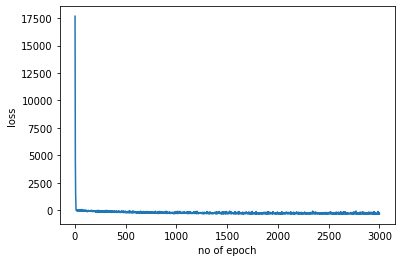

In [18]:
import matplotlib.pyplot as plt
x=[i+1 for i in range (3000)]




plt.plot(x,total_loss)
plt.xlabel('no of epoch')
plt.ylabel('loss')
plt.show()


Once Network A has been trained, iterate over the entire training set and obtain the corresponding
trained vectors for all images. Plot these vectors on a two dimensional t-SNE plot and save it as
“1.3.png”. The points in the plot should be colored based on the ground truth labels. Have a legend
specifying which color corresponds to which digit. Write as briefly as possible about your observations
from this t-SNE plot.

plotting the final vectors on 2d plane

In [19]:
t = torch.tensor(df2.iloc[:,:].values).view(-1,28,28).unsqueeze(1)
print(t.shape)
vec = model(t.float())
print(vec.shape)

from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, verbose=1).fit_transform(vec.detach().numpy())


torch.Size([10000, 1, 28, 28])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([10000, 32])
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.032s...
[t-SNE] Computed neighbors for 10000 samples in 2.057s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.969063
[t-SNE] KL divergence after 1000 iterations: 0.629843


In [0]:
colours=[]
colours.append(1)
j=0
for i in range(1,10000):
  if i%1000==0:
    j+=1
  colours.append(j)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


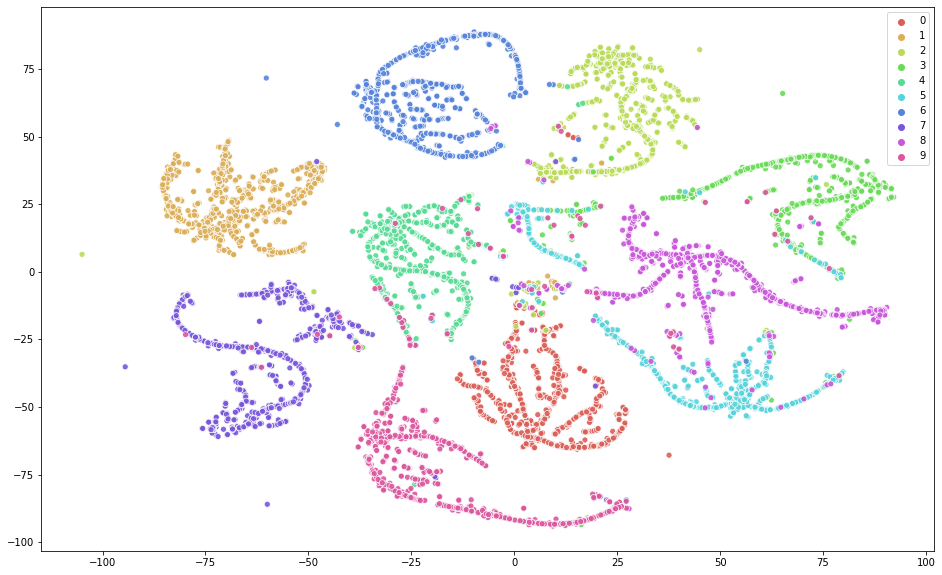

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=X_embedded[:,0], y=X_embedded[:,1],
    hue=colours,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.9
)

Freeze the learned vectors and use them as features to train a multi-class logistic regression classifier
(use sklearn). Report the accuracy on the training set. Now take all examples from the test set, obtain
the vectors corresponding to them by using the already trained Network A (do not use test set for
training Network A). Pass these vectors as features to the already trained logistic regression classifier
(again, please don’t train the logistic regression classifier using examples from test set) and report the
accuracy on the test set. Specify the value of all the hyperparameters that were used by you.

training error for logistic regression

In [22]:
from sklearn.linear_model import LogisticRegression as logR

t = torch.tensor(df2.iloc[:,:].values).view(-1,28,28).unsqueeze(1)
print(t.shape)
vec = model(t.float())
print(vec.shape)

label=[]
for i in range(10):
  for j in range(1000):
    label.append(i)
ran=np.random.randint(0,1000,1000)

log_regr=logR().fit(vec.cpu().detach().numpy(),label)
print(log_regr.score(vec.cpu().detach().numpy(),label))



torch.Size([10000, 1, 28, 28])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([10000, 32])
0.9543


In [0]:
ran=np.random.randint(0,10000,10000)
label=np.array(label)
vec_t=vec[ran]
label_t=label[ran]
#print(label_t.shape)
log_r=logR().fit(vec_t.cpu().detach().numpy(),label_t)

# print(log_r.predict(vec_t.cpu().detach().numpy()))

test error for logistic regression

In [24]:
df_test = pd.read_csv('sample_data/mnist_test.csv', header=None)

df_n=df_test.drop(df.columns[0],axis=1).copy()
print(df_n.head())
label1=df_test.values[:,0]


t1= torch.tensor(df_n.iloc[:,:].values).view(-1,28,28).unsqueeze(1)
print(t.shape)

vec1 = model(t1.float())
print(label1)
print(log_r.score(vec1.cpu().detach().numpy(),label1))



conv1_wt=model.conv1.weight
conv2_wt=model.conv2.weight
fc1_wt=model.fc1.weight



   1    2    3    4    5    6    7    ...  778  779  780  781  782  783  784
0    0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
1    0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
2    0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
3    0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
4    0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0

[5 rows x 784 columns]
torch.Size([10000, 1, 28, 28])
[7 2 1 ... 4 5 6]
0.9433


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


A multi-class logistic regression classifier is almost equivalent to a single layer neural network. Now
take the pretrained Network A and add one more layer to it having 10 units (one for each of the digits).
Let us call this network as Network B. Note that a portion of Network B has to be initialized using
the trained weights of Network A while the last layer has to be randomly initialized. Train Network
B using the negative log likelihood cost function on examples from the training set. As before, plot
the value of the cost function as a function of training iterations in a file called “1.5.png” and report
the classification accuracy of Network B on training and test sets. Also specify the value of various
hyperparameters that were used by you for training. This process is called fine-tuning. Did you obtain
better results in Problem 1.4 or Problem 1.5. Why?

In [0]:
class NetworkB(nn.Module):

    def __init__(self):
        super(NetworkB, self).__init__()
        self.conv1 = nn.Conv2d(1,32,kernel_size=5, dilation=1, stride=1, padding=2,bias=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32,64,kernel_size=5,dilation=1, stride=1, padding=2,bias=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1   = nn.Linear(64*7*7,32)
        self.fc2   = nn.Linear(32, 10)
        self.conv1.weight=conv1_wt
        self.conv2.weight=conv2_wt
        self.fc1.weight=fc1_wt

        # The following dictionary will be useful for directly accessing layers / modules
        self.components = {
            'bb': self.conv2,
            'fc': self.fc1,
            'fc2': self.fc2
        }
        
    def forward(self, input):

        # conv1 + max pool
        out = F.relu(self.conv1(input))
        out = self.pool1(out)
        
        # conv2 + max pool
        out = F.relu(self.conv2(out))
        out = self.pool2(out)
        
        # fc-1
        B,C,H,W = out.size()
        out = out.view(B,-1) 
        out = F.relu(self.fc1(out))
        
        # Logits
        out = self.fc2(out) # Note: Softmax is not applied. We will manually apply during loss calculation.
        
        return out

model = NetworkB()

In [26]:
from torchvision.datasets import MNIST
from torchvision import transforms

transforms = transforms.Compose([
                                #  transforms.RandomRotation(degrees=5),
                                #  transforms.RandomCrop(size=28, padding=4),
                                 transforms.ToTensor()
                                 ])

batch_size = 128

train_dataset = MNIST(root='./mnist_data', download=True, transform=transforms, train=True) # Can use the gdrive path as well: /gdrive_dlcv/My Drive/dlcv/mnist_data
test_dataset = MNIST(root='./mnist_data', download=True, transform=transforms, train=False)
mnist_train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
mnist_test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True)

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw





Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


for experimental purpose i have tried to work with gpu modes of pytorch

In [29]:
model1 = NetworkB().cuda() # Note: Cuda!
optimizer = torch.optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)

max_epochs = 50
max_accuracy = 0.
train_loss=[]
test_loss=[]
load_model = False

if load_model == True:
    msd = torch.load('best_model')
    model1.load_state_dict(msd)
    osd = torch.load('best_optimizer')
    optimizer.load_state_dict(osd)

for e in range(1, max_epochs+1):

    # SET THE MODEL TO TRAIN
    model1.train()

    for dat in mnist_train_dataloader:

        x, y = dat
        n = x.shape[0]

        x = x.cuda() # Note: Cuda!
        y = y.cuda()

        pred = model1(x)

        ''' Method-1 : Manually get the loss '''
        pred_s = F.softmax(pred, dim=-1) # broadcast softmax operation over entire matrix, taking softmax along dim=-1 (last dimension)
        loss_matrix = - torch.log(pred_s)
        total_loss = 0
        for i in range(n):
            total_loss += loss_matrix[i, y[i]]
        loss = total_loss / n

        ''' Method-2 : Convert y into a One-hot vector and broadcast '''
        # pred_s = F.softmax(pred, dim=-1)
        # loss_matrix = - torch.log(pred_s)
        # y_one_hot = F.one_hot(y, num_classes=10) # B x 10
        # total_loss = (y_one_hot * loss_matrix).sum(dim=-1).sum()
        # loss = total_loss 

        ''' Method-3 : nn / functional inbuilt losses '''
        # loss_fn = nn.CrossEntropyLoss(reduction='sum')
        # total_loss = loss_fn(pred, y) # Note, softmax is calculated internally
        # loss = total_loss / n

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
    train_loss.append(loss)

    # SET THE MODEL TO EVAL
    model1.eval()
    
    total_correct = 0.
    total_count = 0.

    with torch.no_grad():

        for dat in mnist_test_dataloader:

            x, y = dat

            x = x.cuda()
            y = y.cuda()

            p = model1(x)
            highest_act, pred_label = torch.max(p, dim=-1)

            total_correct += (pred_label == y).sum()
            total_count += x.shape[0]

    print('\nepoch', e)
    acc = total_correct / total_count
    test_loss.append(1-acc)
    print('Test accuracy:', acc)

    # Condition to save the model / optimizer state
    if acc > max_accuracy:
        max_accuracy = acc
        torch.save(model1.state_dict(), 'best_model')
        torch.save(optimizer.state_dict(), 'best_optimizer')


epoch 1
Test accuracy: tensor(0.9735, device='cuda:0')

epoch 2
Test accuracy: tensor(0.9775, device='cuda:0')

epoch 3
Test accuracy: tensor(0.9806, device='cuda:0')

epoch 4
Test accuracy: tensor(0.9799, device='cuda:0')

epoch 5
Test accuracy: tensor(0.9827, device='cuda:0')

epoch 6
Test accuracy: tensor(0.9827, device='cuda:0')

epoch 7
Test accuracy: tensor(0.9828, device='cuda:0')

epoch 8
Test accuracy: tensor(0.9835, device='cuda:0')

epoch 9
Test accuracy: tensor(0.9835, device='cuda:0')

epoch 10
Test accuracy: tensor(0.9854, device='cuda:0')

epoch 11
Test accuracy: tensor(0.9860, device='cuda:0')

epoch 12
Test accuracy: tensor(0.9865, device='cuda:0')

epoch 13
Test accuracy: tensor(0.9862, device='cuda:0')

epoch 14
Test accuracy: tensor(0.9867, device='cuda:0')

epoch 15
Test accuracy: tensor(0.9866, device='cuda:0')

epoch 16
Test accuracy: tensor(0.9870, device='cuda:0')

epoch 17
Test accuracy: tensor(0.9876, device='cuda:0')

epoch 18
Test accuracy: tensor(0.9867, 

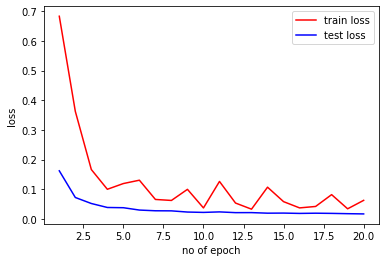

In [28]:
import matplotlib.pyplot as plt
x=[i+1 for i in range (20)]




plt.plot(x,train_loss,color='red')
plt.plot(x,test_loss,color='blue')
plt.xlabel('no of epoch')
plt.ylabel('loss')
plt.legend(['train loss','test loss'])
plt.show()

The reason why neural network works better than logistic regression are the following reasons

1. The “classic” application of logistic regression model is binary classification. However, we can also use “flavors” of logistic to tackle multi-class classification problems, e.g., using the One-vs-All or One-vs-One approaches, via the related softmax regression / multinomial logistic regression. Both these approaches have inherent problems. One pattern may belong to more than one class or may not belong to any class at all.

2. Another reason why NN works better than logistic regression maybe different activation functions in NN , like tanh works better than the sigmoidal function.

